<a href="https://colab.research.google.com/github/ramirojc/Mentoria/blob/master/2_1_TPractico2_ExploracionCuracion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduccion, Analisis y Curacion de Datos

## Diplodatos 2020, Mentorias
### Mentor: Ramiro Caro

In [1]:
# !pip install geopandas
# !apt install libspatialindex-dev
# !pip install rtree
# !pip install osmnx
# !pip install contextily

## Introduccion, carga de datos

A partir de este punto, utilizaremos los transformadores de distribucion como elemnto de analisis, e incorporaremos datos de consumidores, subestacion y lineas de distribucion.

In [4]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString
import contextily as ctx
from scipy.spatial import cKDTree
from utils import display_markdown
import networkx as nx

In [5]:
# Editar con el path correspondiente a sus datos
data_path = 'data/SULGIPE_46_2018-12-31_M10_20190611-1750.gdb'

In [6]:
untrd = gpd.read_file(data_path, driver='FileGDB', layer='UNTRD')
untrd = untrd.to_crs(epsg=31984)
untrd.shape, untrd.columns

((10508, 33),
 Index(['COD_ID', 'DIST', 'PAC_1', 'PAC_2', 'PAC_3', 'FAS_CON_P', 'FAS_CON_S',
        'FAS_CON_T', 'SIT_ATIV', 'TIP_UNID', 'POS', 'ATRB_PER', 'TEN_LIN_SE',
        'CAP_ELO', 'CAP_CHA', 'TAP', 'CONF', 'POSTO', 'POT_NOM', 'PER_FER',
        'PER_TOT', 'DAT_CON', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ', 'MUN', 'BANC',
        'TIP_TRAFO', 'MRT', 'DESCR', 'ARE_LOC', 'geometry'],
       dtype='object'))

In [7]:
untrs = gpd.read_file(data_path, driver='FileGDB', layer='UNTRS')
untrs.shape, untrs.columns

((17, 53),
 Index(['COD_ID', 'SUB', 'BARR_1', 'BARR_2', 'BARR_3', 'PAC_1', 'PAC_2',
        'PAC_3', 'DIST', 'FAS_CON_P', 'FAS_CON_S', 'FAS_CON_T', 'SIT_ATIV',
        'TIP_UNID', 'POS', 'POT_NOM', 'POT_F01', 'POT_F02', 'PER_FER',
        'PER_TOT', 'BANC', 'DAT_CON', 'CONJ', 'MUN', 'TIP_TRAFO', 'ALOC_PERD',
        'ENES_01', 'ENES_02', 'ENES_03', 'ENES_04', 'ENES_05', 'ENES_06',
        'ENES_07', 'ENES_08', 'ENES_09', 'ENES_10', 'ENES_11', 'ENES_12',
        'ENET_01', 'ENET_02', 'ENET_03', 'ENET_04', 'ENET_05', 'ENET_06',
        'ENET_07', 'ENET_08', 'ENET_09', 'ENET_10', 'ENET_11', 'ENET_12',
        'DESCR', 'ARE_LOC', 'geometry'],
       dtype='object'))

In [8]:
ssmt = gpd.read_file(data_path, driver='FileGDB', layer='SSDMT') # the electrical lines
ssmt.columns

Index(['COD_ID', 'PN_CON_1', 'PN_CON_2', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ',
       'DIST', 'PAC_1', 'PAC_2', 'FAS_CON', 'TIP_CND', 'POS', 'ODI_FAS',
       'TI_FAS', 'ODI_NEU', 'TI_NEU', 'COMP', 'DESCR', 'SITCONTFAS',
       'SITCONTNEU', 'ARE_LOC', 'Shape_Length', 'geometry'],
      dtype='object')

In [9]:
segcon = gpd.read_file(data_path, driver='FileGDB', layer='SEGCON')
segcon.columns, segcon.columns

(Index(['COD_ID', 'DIST', 'GEOM_CAB', 'FORM_CAB', 'MAT_FAS_1', 'MAT_FAS_2',
        'MAT_FAS_3', 'MAT_NEU', 'ISO_FAS_1', 'ISO_FAS_2', 'ISO_FAS_3',
        'ISO_NEU', 'CND_FAS', 'R1', 'X1', 'FTRCNV', 'CNOM', 'CMAX', 'CM_FAS',
        'TUC_FAS', 'A1_FAS', 'A2_FAS', 'A3_FAS', 'A4_FAS', 'A5_FAS', 'A6_FAS',
        'CM_NEU', 'TUC_NEU', 'A1_NEU', 'A2_NEU', 'A3_NEU', 'A4_NEU', 'A5_NEU',
        'A6_NEU', 'DESCR', 'BIT_FAS_1', 'BIT_FAS_2', 'BIT_FAS_3', 'BIT_NEU',
        'geometry'],
       dtype='object'),
 Index(['COD_ID', 'DIST', 'GEOM_CAB', 'FORM_CAB', 'MAT_FAS_1', 'MAT_FAS_2',
        'MAT_FAS_3', 'MAT_NEU', 'ISO_FAS_1', 'ISO_FAS_2', 'ISO_FAS_3',
        'ISO_NEU', 'CND_FAS', 'R1', 'X1', 'FTRCNV', 'CNOM', 'CMAX', 'CM_FAS',
        'TUC_FAS', 'A1_FAS', 'A2_FAS', 'A3_FAS', 'A4_FAS', 'A5_FAS', 'A6_FAS',
        'CM_NEU', 'TUC_NEU', 'A1_NEU', 'A2_NEU', 'A3_NEU', 'A4_NEU', 'A5_NEU',
        'A6_NEU', 'DESCR', 'BIT_FAS_1', 'BIT_FAS_2', 'BIT_FAS_3', 'BIT_NEU',
        'geometry'],
       dtype='

In [10]:
ucbt = gpd.read_file(data_path, driver='FileGDB', layer='UCBT')
ucbt.columns, ucbt.columns

(Index(['DIST', 'PAC', 'PN_CON', 'UNI_TR_D', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ',
        'MUN', 'BRR', 'CEP', 'CLAS_SUB', 'CNAE', 'TIP_CC', 'FAS_CON', 'GRU_TEN',
        'TEN_FORN', 'GRU_TAR', 'SIT_ATIV', 'DAT_CON', 'CAR_INST', 'LIV',
        'ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07',
        'ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12', 'DIC', 'FIC',
        'SEMRED', 'DESCR', 'ARE_LOC', 'geometry'],
       dtype='object'),
 Index(['DIST', 'PAC', 'PN_CON', 'UNI_TR_D', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ',
        'MUN', 'BRR', 'CEP', 'CLAS_SUB', 'CNAE', 'TIP_CC', 'FAS_CON', 'GRU_TEN',
        'TEN_FORN', 'GRU_TAR', 'SIT_ATIV', 'DAT_CON', 'CAR_INST', 'LIV',
        'ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07',
        'ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12', 'DIC', 'FIC',
        'SEMRED', 'DESCR', 'ARE_LOC', 'geometry'],
       dtype='object'))

## Informacion sobre consumindores

1 - *En base a los resultados obtenidos en el practico 1. Defina que informacion sobre consumidores, es la mas relevante para la estimacion de calidad de servicio.*

La información que creo es más relevante involucra:

* Ubicación geográfica del consumidor, ya que la calidad varía de acuerdo a si la zona es urbana o rural (variables CONJ, MUN, BRR, CEP, ARE_LOC).
* Cantidad de consumo, ya que las unidades que consumen más parecen ser las que más cortes sufren (variables ENE_*).
* Actividad económica realizada por el consumidor, ya que hay algunas actividades que consumen más que otras, y unidades que varían en frecuencia de corte de acuerdo a la actividad económica (variable CNAE).
* Frecuencia y duración de los cortes (variables DIC y FIC).



In [11]:
ene_col_names = ['ENE_{:02}'.format(i) for i in range(1, 13)]
ucbt_relevant_num_col_names = ene_col_names + ['DIC', 'FIC']
ucbt_relevant_col_names = (
    ['UNI_TR_D', 'UNI_TR_S', 'CONJ', 'MUN', 'BRR', 'CEP', 'ARE_LOC', 'CNAE'] +
    ucbt_relevant_num_col_names
)

2 - *Realize el tratamiento de las filas con valores invalidos y outliers, y luego agrupe los datos en base a la variable UNI_TF_D.*
¿Qué tan completo está ucbt? Veamos proporciones de cantidades de filas sin datos nulos:

In [12]:
total_len = len(ucbt)
len_without_na = len(ucbt.dropna())
prop = len_without_na / total_len
display_markdown('{} / {} = **{:.2%}**'.format(len_without_na, total_len, prop))
"""
if prop < 1.0:
    display_markdown('Valores nulos por columna:')
    missing_values_count = dataframe.isnull().sum()
    for key, value in missing_values_count[missing_values_count > 0].items():
        display_markdown('* **{}** tiene {} valores nulos'.format(key, value))
    print()
""";

148801 / 148801 = **100.00%**

Vemos que el conjunto de datos está completo.

Ahora veamos qué cantidad de valores atípicos hay en ucbt:

In [13]:
for col_name in ucbt[ucbt_relevant_num_col_names]:
    value_is_outlier = (
        (ucbt[col_name] - ucbt[col_name].mean()).abs() > 3 * ucbt[col_name].std()
    )
    outliers_len = len(ucbt[col_name][value_is_outlier])
    total_len = len(ucbt[col_name])
    display_markdown('* **{}**: {} / {} = **{:.2%}**'.format(
        col_name,
        outliers_len,
        total_len,
        outliers_len / total_len
    ))

* **ENE_01**: 77 / 148801 = **0.05%**

* **ENE_02**: 99 / 148801 = **0.07%**

* **ENE_03**: 75 / 148801 = **0.05%**

* **ENE_04**: 81 / 148801 = **0.05%**

* **ENE_05**: 75 / 148801 = **0.05%**

* **ENE_06**: 69 / 148801 = **0.05%**

* **ENE_07**: 70 / 148801 = **0.05%**

* **ENE_08**: 69 / 148801 = **0.05%**

* **ENE_09**: 78 / 148801 = **0.05%**

* **ENE_10**: 75 / 148801 = **0.05%**

* **ENE_11**: 90 / 148801 = **0.06%**

* **ENE_12**: 79 / 148801 = **0.05%**

* **DIC**: 2976 / 148801 = **2.00%**

* **FIC**: 1652 / 148801 = **1.11%**

Vemos que hay más valores atípicos en las columnas DIC y FIC. Hagamos gráficos de caja de estas varaibles:

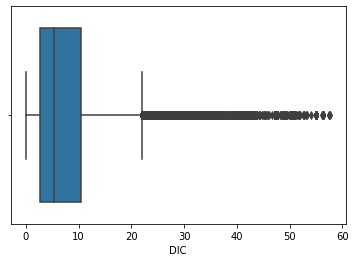

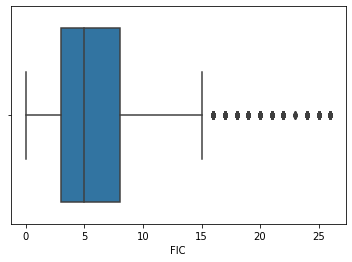

In [14]:
plt.figure()
sns.boxplot(ucbt.DIC)
plt.figure()
sns.boxplot(ucbt.FIC)

¿Qué tal si graficamos las variables sin valores atípicos?

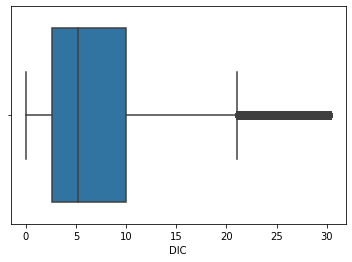

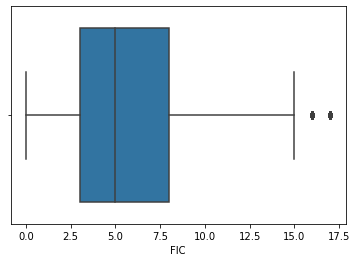

In [15]:
dic_is_outlier = (ucbt.DIC - ucbt.DIC.mean()).abs() > 3 * ucbt.DIC.std()
fic_is_outlier = (ucbt.FIC - ucbt.FIC.mean()).abs() > 3 * ucbt.FIC.std()

plt.figure()
sns.boxplot(ucbt[~dic_is_outlier].DIC)
plt.figure()
sns.boxplot(ucbt[~fic_is_outlier].FIC)

Así se ve mejor.

Eliminemos los consumidores que tengan valores atípicos en DIC o en FIC y quedémonos sólo con las columnas que nos interesan. Además, agrupemos a los consumidores por transformador de distribución:



In [16]:
clean_ucbt = ucbt[~dic_is_outlier & ~fic_is_outlier][ucbt_relevant_col_names]

agg_dict = {
    'UNI_TR_S': 'first',
    'DIC': 'median',
    'FIC': 'median',
    'CNAE': pd.Series.mode
}
for ene_col_name in ene_col_names:
    agg_dict[ene_col_name] = 'sum'
ext_untrd = clean_ucbt.groupby('UNI_TR_D').agg(agg_dict)

ext_untrd = untrd[['COD_ID', 'CONJ', 'MUN', 'ARE_LOC', 'geometry']].merge(ext_untrd, left_on='COD_ID', right_on='UNI_TR_D')

ext_untrd

,COD_ID,CONJ,MUN,ARE_LOC,geometry,UNI_TR_S,DIC,FIC,CNAE,ENE_01,...,ENE_03,ENE_04,ENE_05,ENE_06,ENE_07,ENE_08,ENE_09,ENE_10,ENE_11,ENE_12
0,4_1040341,12737,2805802,NU,POINT (627712.617 8776098.670),1_SESAQ_1,7.050,8.0,0,147.0,...,150.0,115.0,140.0,162.0,148.0,202.0,204.0,189.0,195.0,160.0
1,4_1040306,12737,2805802,NU,POINT (626353.418 8777498.606),1_SESAQ_1,5.470,7.0,0,275.0,...,263.0,256.0,204.0,367.0,275.0,241.0,278.0,247.0,296.0,287.0
2,4_1040035,12737,2805802,NU,POINT (635724.137 8773322.662),1_SESAQ_1,7.130,7.0,0,1732.0,...,1413.0,1647.0,1632.0,1553.0,1590.0,1554.0,1773.0,1623.0,1871.0,1456.0
3,13_1130368,12743,2917904,NU,POINT (631104.558 8720058.235),2_SETMG_1,9.965,6.0,0,2026.0,...,2199.0,1923.0,2929.0,2216.0,1782.0,3007.0,3407.0,2763.0,3321.0,2949.0
4,4_1040036,12737,2805802,NU,POINT (638696.486 8773991.732),1_SESAQ_1,5.190,6.0,0,692.0,...,604.0,697.0,728.0,577.0,544.0,593.0,590.0,532.0,653.0,608.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,14_1141247,12743,2927002,NU,POINT (626315.918 8721661.183),2_SETMG_1,13.990,8.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.0,51.0,164.0,108.0,57.0
8829,8_1080557,12730,2802809,NU,POINT (673768.068 8730109.019),1_SECON_1,11.435,6.0,0,69.0,...,58.0,57.0,91.0,103.0,86.0,91.0,110.0,107.0,97.0,115.0
8830,2_1020110,15600,2800670,UB,POINT (651696.927 8768311.258),2_SEAUA_1,1.900,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,73.0,67.0
8831,9_2090010,12730,2806305,NU,POINT (672089.772 8741871.181),1_SECON_1,10.600,5.0,3600601,1557.0,...,1611.0,1521.0,1711.0,1487.0,1502.0,1639.0,1719.0,1592.0,1630.0,1028.0


3 - *Justifique los metodos utilizados para agrupar las variables numericas y categoricas.*

Con respecto a las variables numéricas decido:

sumar las de consumo de energía (ENE_*) para así tener cantidad de energía activa de cada transformador por período,
sacar medidas de tendencia central tanto para DIC como para FIC para tener una idea de más o menos cuánto duran los cortes y qué tan frecuentes son en cada transformador, respectivamente. Dadas las formas de las distribuciones de DIC y FIC (no simétricas, la primera tal vez con forma de Possion y la segunda con forma exponencial o gamma), la medianas me parecen más adecuadas que las medias ya que estas últimas se ven bastante afectadas por valores muy grandes.
Con respecto a las variables categóricas, me quedo con:

unidad transformadora de segmentación (UNI_TR_S) para la cual elijo el primer elemento del grupo, ya que cada unidad transformadora de distribución tiene exactamente una unidad transformadora de segmentación.
actividad económica (CNAE) para la cual elijo la moda como actividad principal por cada transformador.
A CONJ, MUN y ARE_LOC las saco de untrd haciendo merge.

## Informacion sobre subestacion

4 - Analise la informacion disponible sobre los transformadores de segmentacion (UNI_TR_S > UNTRS)

In [17]:
print(untrs.shape)
untrs.describe()

(17, 53)


,DIST,POT_NOM,POT_F01,POT_F02,PER_FER,PER_TOT,BANC,CONJ,ENES_01,ENES_02,...,ENET_03,ENET_04,ENET_05,ENET_06,ENET_07,ENET_08,ENET_09,ENET_10,ENET_11,ENET_12
count,17.0,17.000000,17.0,17.0,17.000000,17.000000,17.0,17.000000,1.700000e+01,1.700000e+01,...,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0
mean,46.0,6.764706,0.0,0.0,0.131765,0.608824,0.0,14084.529412,1.397955e+07,1.426265e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,3.509441,0.0,0.0,0.082404,0.175957,0.0,1473.628520,4.635029e+06,4.650536e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,46.0,5.000000,0.0,0.0,0.100000,0.530000,0.0,12730.000000,1.041005e+07,1.067506e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,46.0,5.000000,0.0,0.0,0.100000,0.530000,0.0,12737.000000,1.160140e+07,1.165818e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,46.0,5.000000,0.0,0.0,0.100000,0.530000,0.0,12743.000000,1.290811e+07,1.340045e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,46.0,5.000000,0.0,0.0,0.100000,0.530000,0.0,15601.000000,1.352022e+07,1.388548e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,46.0,15.000000,0.0,0.0,0.350000,1.060000,0.0,15602.000000,2.589224e+07,2.617161e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
n_cols_p_step = 6
for i in range(0, len(untrs.columns), n_cols_p_step):
    col_names = untrs.columns[i:i + n_cols_p_step]
    print(untrs[col_names])
    print(untrs[col_names].nunique())
    print()

       COD_ID    SUB   BARR_1   BARR_2   BARR_3        PAC_1
0   2_SETMG_1  SETMG  SETMG_1  SETMG_1           SETMG_1_2_2
1   1_SEITI_1  SEITI  SEITI_1  SEITI_1           SEITI_1_1_2
2   2_SEAUA_1  SEAUA  SEAUA_1  SEAUA_1           SEAUA_1_2_2
3   1_SETMG_1  SETMG  SETMG_1  SETMG_1           SETMG_1_1_2
4   1_SEAUA_1  SEAUA  SEAUA_1  SEAUA_1  SEAUA_2  SEAUA_1_1_2
5   2_SEITI_1  SEITI  SEITI_1  SEITI_1           SEITI_1_2_2
6   1_SESAQ_1  SESAQ  SESAQ_1  SESAQ_1           SESAQ_1_1_2
7   1_SECON_1  SECON  SECON_1  SECON_1           SECON_1_1_2
8   3_SEITI_1  SEITI  SEITI_1  SEITI_1           SEITI_1_3_2
9   2_SESAQ_1  SESAQ  SESAQ_1  SESAQ_1           SESAQ_1_2_2
10  3_SETMG_1  SETMG  SETMG_1  SETMG_1           SETMG_1_3_2
11  3_SESAQ_1  SESAQ  SESAQ_1  SESAQ_1           SESAQ_1_3_2
12  3_SEAUA_1  SEAUA  SEAUA_1  SEAUA_1           SEAUA_1_3_2
13  3_SECON_1  SECON  SECON_1  SECON_1           SECON_1_3_2
14  2_SECON_1  SECON  SECON_1  SECON_1           SECON_1_2_2
15  1_SEEST_1  SEEST  SE

5 - *Seleccione las variables relevantes, realize tratamiento de valores invalidos y outliers correspondientes. Agrupe los valores por UNTRD y agregue al dataset.*

In [21]:
enes_col_names = ['ENES_{:02}'.format(i) for i in range(1, 13)]
untrs_relevant_col_names = ['COD_ID', 'SUB', 'BARR_1', 'BARR_2', 'BARR_3',
                            'POT_NOM', 'PER_FER', 'PER_TOT', 'DAT_CON',
                            'CONJ', 'MUN', 'geometry'] + enes_col_names

clean_untrs = untrs[untrs_relevant_col_names]

dataframe = ext_untrd.merge(clean_untrs.add_prefix('TR_S_'), left_on='UNI_TR_S', right_on='TR_S_COD_ID')

dataframe

,COD_ID,CONJ,MUN,ARE_LOC,geometry,UNI_TR_S,DIC,FIC,CNAE,ENE_01,...,TR_S_ENES_03,TR_S_ENES_04,TR_S_ENES_05,TR_S_ENES_06,TR_S_ENES_07,TR_S_ENES_08,TR_S_ENES_09,TR_S_ENES_10,TR_S_ENES_11,TR_S_ENES_12
0,4_1040341,12737,2805802,NU,POINT (627712.617 8776098.670),1_SESAQ_1,7.050,8.0,0,147.0,...,13310184.0,13444950.0,13191438.0,12313358.0,11755778.0,12337156.0,12848866.0,12691834.0,13943276.0,13033788.0
1,4_1040306,12737,2805802,NU,POINT (626353.418 8777498.606),1_SESAQ_1,5.470,7.0,0,275.0,...,13310184.0,13444950.0,13191438.0,12313358.0,11755778.0,12337156.0,12848866.0,12691834.0,13943276.0,13033788.0
2,4_1040035,12737,2805802,NU,POINT (635724.137 8773322.662),1_SESAQ_1,7.130,7.0,0,1732.0,...,13310184.0,13444950.0,13191438.0,12313358.0,11755778.0,12337156.0,12848866.0,12691834.0,13943276.0,13033788.0
3,4_1040036,12737,2805802,NU,POINT (638696.486 8773991.732),1_SESAQ_1,5.190,6.0,0,692.0,...,13310184.0,13444950.0,13191438.0,12313358.0,11755778.0,12337156.0,12848866.0,12691834.0,13943276.0,13033788.0
4,4_1040038,12737,2805802,NU,POINT (638310.799 8773035.106),1_SESAQ_1,5.840,7.0,0,1297.0,...,13310184.0,13444950.0,13191438.0,12313358.0,11755778.0,12337156.0,12848866.0,12691834.0,13943276.0,13033788.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,8_1080578,12730,2802809,NU,POINT (653013.399 8739601.889),1_SECON_1,21.510,10.0,0,1206.0,...,9629278.0,9519481.0,8886469.0,8563985.0,7908330.0,8312732.0,8856697.0,8965352.0,9627315.0,9212908.0
8829,8_1080577,12730,2802809,NU,POINT (653309.344 8739968.353),1_SECON_1,21.510,10.0,0,1469.0,...,9629278.0,9519481.0,8886469.0,8563985.0,7908330.0,8312732.0,8856697.0,8965352.0,9627315.0,9212908.0
8830,12_1120421,12730,2807600,NU,POINT (644710.911 8734252.079),1_SECON_1,21.130,9.0,0,189.0,...,9629278.0,9519481.0,8886469.0,8563985.0,7908330.0,8312732.0,8856697.0,8965352.0,9627315.0,9212908.0
8831,8_1080557,12730,2802809,NU,POINT (673768.068 8730109.019),1_SECON_1,11.435,6.0,0,69.0,...,9629278.0,9519481.0,8886469.0,8563985.0,7908330.0,8312732.0,8856697.0,8965352.0,9627315.0,9212908.0


## Generacion de variables en base a puntos de referencia

5 - *Calcule la distancia euclideana de cada untrd al correspondiente untrs y adicione al dataset.*

In [22]:
dataframe['DIST'] = dataframe.geometry.distance(dataframe.TR_S_geometry[0])

6 - *Cree una variable que sea la distancia media a los tres centros urbanos mas cercanos.*

In [23]:
#untrd['dist_urbcen'] = untrd.distance(urban_cen???)

7 - *Usando OSMnx descargue la informacion sobre caminos dentro del area de cobertura de la distribuidora. Cree variables para las distancias a autopistas (trunk), a caminos primarios (primary) y a caminos secundarios (secondary)*

In [24]:
#Calcule la distancia euclideana de cada untrd al correspondiente untrs y adicione al dataset.
dist_untrs = untrd.distance(untrs.geometry[0])
untrd['dist_untrs'] = dist_untrs

In [25]:
#Cree una variable que sea la distancia media a los tres centros urbanos mas cercanos.
## tres centros urbanos mas cercas
centro_1 = 'Itabaianinha, Sergipe, Brazil'
centro_2 = 'Tomar do Geru, Sergipe, Brazil'
centro_3 = 'Arauá, Sergipe, Brazil'

## Generacion de variables con arboles de busqueda

8 - Cree variables que indique la cantidad de consumidores en radios de 25, 50 y 100 metros del transformador.

9 - Cree una variable indicando la distancia media de cada fila a los 5 untrd mas cercanos.

10 - [Opcional] Usando OSMnx descargue los footprints de edificios disponibles, y cree una variable que indique la cantidad de edificios en un radio de 200 metros al transformador.

In [27]:
# Cree variables que indique la cantidad de consumidores en radios de 25, 50 y 100 metros del transformador.
# ucbt = gpd.read_file(data_path, driver='FileGDB', layer='UCBT')
# ucbt = ucbt.to_crs(epsg=31984)
# ucbt.shape

(148801, 40)

In [29]:
# Convertimos las coordenas a una matriz
ucbt_loc_array = [x.coords[0] for x in ucbt.geometry]
untrd_loc_array = [x.coords[0] for x in untrd.geometry]

In [30]:
print(untrd_loc_array[:10])

[(627712.6169779997, 8776098.670127511), (626353.4179798126, 8777498.606078334), (632355.4149737856, 8753247.956105636), (635724.1370160332, 8773322.662057359), (631104.5580278498, 8720058.23505237), (638696.4859638879, 8773991.73208276), (638310.7990282972, 8773035.106081862), (623701.882989638, 8737730.572129583), (638236.557017495, 8772759.907124765), (626993.9699670533, 8775185.16404461)]


In [31]:
radio = 25
radio1 = 50
radio2 = 100
tree = cKDTree(ucbt_loc_array)
near_consumers = tree.query_ball_point(untrd_loc_array, radio)
near_consumers1 = tree.query_ball_point(untrd_loc_array, radio1)
near_consumers2 = tree.query_ball_point(untrd_loc_array, radio2)

In [32]:
print(near_consumers[:10])

[list([100083]) list([104711])
 list([15668, 15669, 15671, 15673, 15674, 15951, 15955, 69473, 69474, 69551, 69553, 122579, 122580])
 list([100959]) list([68479])
 list([100563, 100564, 100719, 100720, 100721, 100722, 110816])
 list([116692, 136261]) list([35337]) list([8748, 91949, 91950]) list([])]


In [36]:
# print("Cantidad de consumidores rurales: ",len(near_consumers_rural))
# print("Cantidad de consumidores intermedios: ",len(near_consumers_intermedio))
# print("Cantidad de consumidores urbanos: ",len(near_consumers_urban))

In [37]:
untrd['n_close_con'] = [len(c) for c in near_consumers2]
untrd['is_urb'] =  untrd['n_close_con'] > 50
print(len(untrd[untrd.is_urb == True]))

1201


## Generacion de grafos y calculo de rutas

11 - Usando las tecnicas mostradas en el notebook sobre procesamiento de informacion georeferenciada, construya un grafo basado en la capa de linea de distribicion de media tension:
  - Utilize los puntos de conexion PCON_1 y PCON_2 como nodos, y los segmentos como edges.
  - Adicione COMP y COD_ID como atributos de edge (aristas)
  - Asocie cada transformador untrd con un nodo
  - Asocie cada punto de conexion los circuitos de media tension (CTMT) con la subestacion, a un nodo.

In [38]:
ssmt.head()

,COD_ID,PN_CON_1,PN_CON_2,CTMT,UNI_TR_S,SUB,CONJ,DIST,PAC_1,PAC_2,...,TI_FAS,ODI_NEU,TI_NEU,COMP,DESCR,SITCONTFAS,SITCONTNEU,ARE_LOC,Shape_Length,geometry
0,96609,56314,56315,3_SEAUA_1,1_SEAUA_1,SEAUA,15600,46,563141,563151,...,40,,40,52.49,,AT1,AT1,UB,0.000481,"MULTILINESTRING ((-37.66413 -11.38058, -37.663..."
1,96541,58888,58887,3_SEAUA_1,1_SEAUA_1,SEAUA,15600,46,588881,588871,...,41,,41,51.04,,AT1,AT1,NU,0.000467,"MULTILINESTRING ((-37.64115 -11.38825, -37.640..."
2,96540,58887,58886,3_SEAUA_1,1_SEAUA_1,SEAUA,15600,46,588871,588861,...,41,,41,45.48,,AT1,AT1,NU,0.000416,"MULTILINESTRING ((-37.64154 -11.38812, -37.641..."
3,96180,58845,39086,3_SEAUA_1,1_SEAUA_1,SEAUA,15600,46,588451,390861,...,41,,41,77.48,,AT1,AT1,NU,0.000709,"MULTILINESTRING ((-37.61654 -11.40244, -37.615..."
4,96168,51114,680897,2_SEAUA_1,1_SEAUA_1,SEAUA,15600,46,511141,6808971,...,41,,41,63.38,,AT1,AT1,NU,0.000573,"MULTILINESTRING ((-37.60166 -11.26703, -37.601..."


In [39]:
# Generar grafo basado en la red de distribucion
SG = nx.Graph()
SG.add_weighted_edges_from(ssmt[['PN_CON_1','PN_CON_2','COMP']].values.tolist(), weight='length')

In [40]:
SG.edges['671470', '671471']

{'length': 25.63}

In [41]:
# Puedo agregar mas atributos despues de creado el grafo
# Agrego el COD_ID de cada segmento como atributo de Edge
ID_attr_dict = {tuple((x[0], x[1])): x[2:] for x in ssmt[['PN_CON_1','PN_CON_2','COD_ID','COMP']].values}
nx.set_edge_attributes(SG, ID_attr_dict, 'SEG_ID')

In [42]:
ponnot = gpd.read_file(data_path, driver='FileGDB', layer='PONNOT')
ponnot = ponnot.to_crs(epsg=31984)
ponnot_loc_array = [x.coords[0] for x in ponnot.geometry]
ponnot.shape, ponnot.columns

((124647, 24),
 Index(['COD_ID', 'DIST', 'TIP_PN', 'POS', 'ESTR', 'MAT', 'ESF', 'ALT', 'CONJ',
        'MUN', 'ODI', 'TI', 'CM', 'TUC', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6',
        'SITCONT', 'DESCR', 'ARE_LOC', 'geometry'],
       dtype='object'))

### Create Graph

In [43]:
pn_tree = cKDTree(ponnot_loc_array) # algorithm that makes a tree of nodes
untrd_loc_array = [x.coords[0] for x in untrd.geometry]
pnd, pni = pn_tree.query(untrd_loc_array, n_jobs=-1) # query the tree for the nearest node
# pnd = distances to the nearest neighbors, pni = locations of the neighbors

In [46]:
# for i in pni:
#     print(ponnot.iloc[i].COD_ID)

In [47]:
untrd['NODE'] = [ponnot.iloc[i].COD_ID for i in pni] 

### Set the CTMT for each circuit

In [48]:
ctmt_endpoints = pd.read_csv('./data/endpoints_utf.csv')
ep_dict = {row.CTMT: str(row.PONNOT) for i,row in ctmt_endpoints.iterrows()} 
# this is a dictionary of the post at the source (the subestacion) of the main line a.k.a. the "ENDNODE"

In [49]:
untrd['ENDNODE'] = untrd.CTMT.map(ep_dict)

In [50]:
untrd[untrd.NODE.isna()]

,COD_ID,DIST,PAC_1,PAC_2,PAC_3,FAS_CON_P,FAS_CON_S,FAS_CON_T,SIT_ATIV,TIP_UNID,...,TIP_TRAFO,MRT,DESCR,ARE_LOC,geometry,dist_untrs,n_close_con,is_urb,NODE,ENDNODE


In [51]:
untrd[untrd.ENDNODE.isna()]

,COD_ID,DIST,PAC_1,PAC_2,PAC_3,FAS_CON_P,FAS_CON_S,FAS_CON_T,SIT_ATIV,TIP_UNID,...,TIP_TRAFO,MRT,DESCR,ARE_LOC,geometry,dist_untrs,n_close_con,is_urb,NODE,ENDNODE
4434,5_2051999,46,1111871,ET5_2051999,0,ABC,ABCN,0,AT,38,...,T,0,,NU,POINT (676658.220 8769770.402),8.795851e+06,0,False,111187,NaN
4435,5_2052000,46,1111861,ET5_2052000,0,ABC,ABCN,0,AT,38,...,T,0,,NU,POINT (677226.272 8769627.387),8.795752e+06,0,False,111186,NaN
7940,5_2054000,46,6727481,ET5_2054000,0,ABC,ABCN,0,AT,38,...,T,0,,NU,POINT (674358.386 8762674.380),8.788599e+06,0,False,672748,NaN
8213,5_2050479,46,6599181,ET5_2050479,0,ABC,ABCN,0,AT,38,...,T,0,,UB,POINT (669278.493 8754050.738),8.779612e+06,0,False,659918,NaN


In [52]:
untrd = untrd[untrd.ENDNODE.notna()]
untrd.head()

,COD_ID,DIST,PAC_1,PAC_2,PAC_3,FAS_CON_P,FAS_CON_S,FAS_CON_T,SIT_ATIV,TIP_UNID,...,TIP_TRAFO,MRT,DESCR,ARE_LOC,geometry,dist_untrs,n_close_con,is_urb,NODE,ENDNODE
0,4_1040341,46,452971,ET4_1040341,0,ABC,ABCN,0,AT,38,...,T,0,,NU,POINT (627712.617 8776098.670),8.798533e+06,1,False,45297,44304
1,4_1040306,46,452681,ET4_1040306,0,ABC,ABCN,0,AT,38,...,T,0,,NU,POINT (626353.418 8777498.606),8.799832e+06,1,False,45268,44304
2,7_2070013,46,600021,ET7_2070013,0,ABC,ABCN,0,AT,38,...,T,0,,UB,POINT (632355.415 8753247.956),8.776074e+06,195,True,60002,48689
3,4_1040035,46,462831,ET4_1040035,ET4_1040035,AB,AN,BN,AT,38,...,MT,0,,NU,POINT (635724.137 8773322.662),8.796339e+06,14,False,46283,44304
4,13_1130368,46,148261,ET13_1130368,0,ABC,ABCN,0,AT,38,...,T,0,,NU,POINT (631104.558 8720058.235),8.742880e+06,4,False,14826,17749


12 - Seleccione al menos 5 metricas de grafo, calcule sus valores para los nodos asociados a cada fila y adicionelos como features al dataset.

### Generar Metricas

In [53]:
print('#1 - Degree')
g_degree = SG.degree(untrd.NODE)
print('#2 - Neighbor degree')
g_avg_ndeg = nx.average_neighbor_degree(SG)
print('#3 - Pagerank')
g_pr = nx.pagerank(SG)
print('#4 - Dispersion')
g_dis = nx.dispersion(SG)
print('#5 - Eigenvector centrality')
eigen = nx.eigenvector_centrality(SG)

#1 - Degree
# 2 - Neighbor degree
#3 - Pagerank
#4 - Dispersion
#5 - Eigenvector centrality


In [ ]:
# Adicionar al grafico como Atributo de los nodos
nx.set_node_attributes(SG, g_degree, 'degree')
nx.set_node_attributes(SG, g_avg_ndeg, 'avg_nei_degree')
nx.set_node_attributes(SG, eigen, 'eigenvector_centrality')
nx.set_node_attributes(SG, g_pr, 'pagerank')
nx.set_node_attributes(SG, g_dis, 'dispersion')

In [63]:
# Mapear valores a al dataframe de transformadores
untrd['g_degree'] = untrd.NODE.map(g_degree)
untrd['g_avg_ndeg'] = untrd.NODE.map(g_avg_ndeg)
untrd['g_pagerank'] = untrd.NODE.map(g_pr)
untrd['g_dispersion'] = untrd.NODE.map(g_dis)
untrd['eigenvector_centrality'] = untrd.NODE.map(eigen)

In [64]:
untrd.head()

,COD_ID,DIST,PAC_1,PAC_2,PAC_3,FAS_CON_P,FAS_CON_S,FAS_CON_T,SIT_ATIV,TIP_UNID,...,n_close_con,is_urb,NODE,ENDNODE,g_degree,g_avg_ndeg,g_pagerank,g_dispersion,eigenvector_centrality,dist_to_trs_dijkstra
0,4_1040341,46,452971,ET4_1040341,0,ABC,ABCN,0,AT,38,...,1,False,45297,44304,2,2.0,0.000012,"{'45298': 0.0, '45296': 0.0}",5.680527e-06,110
1,4_1040306,46,452681,ET4_1040306,0,ABC,ABCN,0,AT,38,...,1,False,45268,44304,1,2.0,0.000007,{'45269': 0.0},2.625699e-06,126
2,7_2070013,46,600021,ET7_2070013,0,ABC,ABCN,0,AT,38,...,195,True,60002,48689,1,3.0,0.000006,{'669661': 0.0},2.395393e-05,38
3,4_1040035,46,462831,ET4_1040035,ET4_1040035,AB,AN,BN,AT,38,...,14,False,46283,44304,2,2.0,0.000012,"{'46285': 0.0, '46282': 0.0}",4.072908e-07,240
4,13_1130368,46,148261,ET13_1130368,0,ABC,ABCN,0,AT,38,...,4,False,14826,17749,2,2.5,0.000011,"{'14825': 0.0, '14812': 0.0}",4.121470e-06,548


14 - Calcule la distancia de cada untrd a su correspondiente punto de conexion con la subestacion, ponderando por COMP (longitud de segmento), utilize el parametro "method" para calcular diferentes tipos de distancias.
Adicione los resultados como variables del dataset.

### Graph Network entre UNTRDs (trandformadores?) <--------> ORIGEN (la subestacion)

In [65]:
nx.shortest_path_length(SG, untrd.NODE[10], untrd.ENDNODE[10], weight='COMP', method='dijkstra')

284

In [66]:
# cuidado. lleva mucho tiempo
untrd['dist_to_trs_dijkstra'] = [nx.shortest_path_length(SG, trd.NODE, trd.ENDNODE, weight='COMP', method='dijkstra') for i, trd in untrd.iterrows()]

In [ ]:
#untrd['dist_to_trs_bellman'] = [nx.shortest_path_length(SG, trd.NODE, trd.ENDNODE, weight='COMP', method='bellman-ford') for i, trd in untrd.iterrows()]

In [ ]:
untrd.head()

In [ ]:
ponnot = gpd.read_file(data_path, driver='FileGDB', layer='PONNOT')
ponnot = ponnot.to_crs(epsg=31984)
ponnot_loc_array = [x.coords[0] for x in ponnot.geometry]
ponnot.shape, ponnot.columns

In [ ]:
untrd.dist_to_trs_dijsktra[10]

In [ ]:
path = nx.shortest_path(SG,untrd.NODE[10], untrd.ENDNODE[10])
ponnot.set_index('COD_ID', inplace=True)
path_ponnot = ponnot.loc[path]
ax = path_ponnot.to_crs(epsg=3857).plot(figsize=(8,8))
ctx.add_basemap(ax, source= ctx.sources.OSM_A)

### Usando las tecnicas mostradas en el notebook sobre procesamiento de informacion georeferenciada, construya un grafo basado en la capa de linea de distribicion de media tension:
- Resistencia electica total de cada conexion
- Reactancia electrica de cada conexion. [Opcional]
- Modulo y Angulo de la Impedancia.
- Corriente Nonimal media a lo largo de la ruta
- Corriente Maxima media del conductor a lo largo la ruta

# Graph network entre SSDMT <--------> ORIGEN (la subestacion)

In [ ]:
# import layer 
ucmt = gpd.read_file(data_path, driver='FileGDB', layer='UCMT')
ucmt = ucmt.to_crs(epsg=31984)
ucmt.shape

In [ ]:
# Generar grafo basado en la red de distribucion
SG = nx.Graph()
SG.add_weighted_edges_from(ssmt[['PN_CON_1','PN_CON_2','COMP']].values.tolist(), weight='length')

In [ ]:
# Puedo agregar mas atributos despues de creado el grafo
# Agrego el COD_ID de cada segmento como atributo de Edge
ID_attr_dict = {tuple((x[0], x[1])): x[2:] for x in ssmt[['PN_CON_1','PN_CON_2','COD_ID','COMP']].values}
nx.set_edge_attributes(SG, ID_attr_dict, 'SEG_ID')

In [ ]:
ponnot = gpd.read_file(data_path, driver='FileGDB', layer='PONNOT')
ponnot = ponnot.to_crs(epsg=31984)
ponnot_loc_array = [x.coords[0] for x in ponnot.geometry]
ponnot.shape, ponnot.columns

## create graph with media tension and subestacion? or los transformadore o los todos????

In [ ]:
pn_tree = cKDTree(ponnot_loc_array) # algorithm that makes a tree of nodes
ucmt_loc_array = [x.coords[0] for x in ucmt.geometry]
pnd, pni = pn_tree.query(ucmt_loc_array, n_jobs=-1) # query the tree for the nearest node
# pnd = distances to the nearest neighbors, pni = locations of the neighbors

In [ ]:
ponnot.columns

In [ ]:
untrd['NODE'] = [ponnot.iloc[i].COD_ID for i in pni] 

#### TODO: add weights from 
* height
* material
* resistance

In [ ]:
# path = nx.shortest_path(SG,ucmt.NODE[10], ucmt.ENDNODE[10])
# ponnot.set_index('COD_ID', inplace=True)
# path_ponnot = ponnot.loc[path]
# ax = path_ponnot.to_crs(epsg=3857).plot(figsize=(8,8))
# ctx.add_basemap(ax, source= ctx.sources.OSM_A)